In [1]:
import os
import glob

image_types = os.listdir('vehicles/')
cars = []
for imtype in image_types:
    cars.extend(glob.glob('vehicles/'+imtype+'/*'))
n_cars = len(cars)
    
print('Number of Vehicle Images found:', n_cars)
with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        
image_types = os.listdir('non-vehicles/')
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob('non-vehicles/'+imtype+'/*'))

n_notcars = len(notcars)    
print('Number of Non-Vehicle Images found:', n_notcars)
with open('notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


# Explore the data

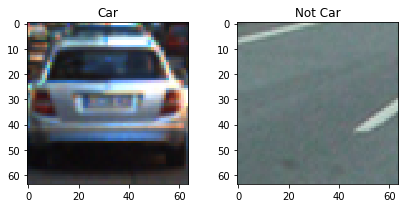

In [11]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
# Define a function for plotting multiple images
def visualise(fig, rows, cols, imgs, titles, cmap='hot'):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.tight_layout()
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap=cmap)
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


# Randomly select the images of car and nonecar
car_ind = np.random.randint(0, n_cars)
notcar_ind = np.random.randint(0, n_notcars)

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

titles = ['Car', 'Not Car']
images = []
images.append(car_image)
images.append(notcar_image)

fig = plt.figure(figsize=(6, 3))
visualise(fig, 1, 2, images, titles)
fig.savefig("output_images/01.car_notcar.jpg")

# Extract Features Training Module

In [3]:
# Extract HOG feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract spatial feature
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Extract color histogram feature
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Covert image to a specific colorspace
def convert_color(img, conv='RGB'):
    if conv == 'RGB':
        return img
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Explore HOG and colour space

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


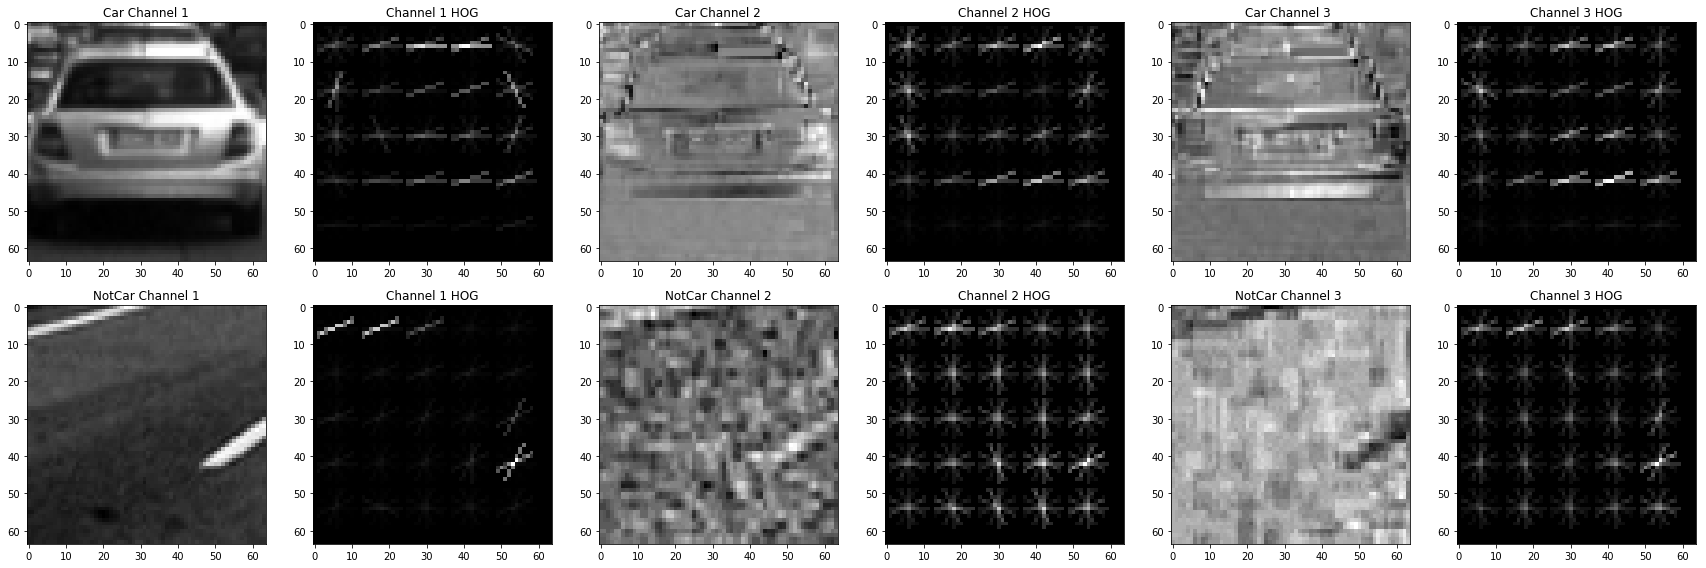

In [12]:
import cv2
from skimage.feature import hog

# Define function to explore the colour space and HOG features
def explore(image, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2):
    
    imgs = []
    imgs.append(image)
    
    feature_image = convert_color(image, conv=color_space)
    
    for i in range(feature_image.shape[2]):
        imgs.append(feature_image[:,:,i])
        hog_feature, hog_img = get_hog_features(feature_image[:,:,i], orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=False)
        imgs.append(hog_img)
    
    return imgs

# Explore HOG and Color spaces
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

images = explore(car_image, orient=10, pix_per_cell=12, color_space=color_spaces[5])[1:]
images.extend(explore(notcar_image, orient=10, pix_per_cell=12, color_space=color_spaces[5])[1:])

titles = ['Car Channel 1', 'Channel 1 HOG', 'Car Channel 2', 'Channel 2 HOG', 'Car Channel 3 ', 'Channel 3 HOG',
          'NotCar Channel 1', 'Channel 1 HOG', 'NotCar Channel 2', 'Channel 2 HOG', 'NotCar Channel 3 ', 'Channel 3 HOG']
fig = plt.figure(figsize=(24,8))
visualise(fig, 2, 6, images, titles, cmap='gray')
fig.savefig("output_images/02.HOG.jpg")

### Features Extraction

In [13]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32), color_space='RGB', hist_bins=32,
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        file_features = []
        image = mpimg.imread(file)
        feature_image = convert_color(image, conv=color_space)
        
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
       
        if hist_feat:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat:
            # Apply get_hog_features() with vis=False, feature_vec=True
            if hog_channel == "ALL":
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True))
                hog_features = np.concatenate(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

In [14]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Extraction feature and prepare data
# Define feature parameters
color_space = 'YCrCb'
orient = 10
pix_per_cell = 12
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

#n_samples = 1000
#random_idxs = np.random.randint(0, n_cars, n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]

t = time.time()
car_feature = extract_features(cars,color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_feature = extract_features(notcars,color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print(time.time()-t,  'Seconds to extract features...')

t = time.time()
X = np.vstack((car_feature, notcar_feature)).astype(np.float64)
# Normlise the features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# Label odata
y = np.hstack((np.ones(len(car_feature)), np.zeros(len(notcar_feature))))

# Shuffle and Split data to training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

print("Training and test data are ready. Taken ", time.time()-t, " seconds.")
print("Feature vector length:", len(X_train[0]))

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


88.41709899902344 Seconds to extract features...
Training and test data are ready. Taken  13.62831997871399  seconds.
Feature vector length: 5088


### Train and evaluate model

In [15]:
from sklearn.svm import SVC, LinearSVC

t1 = time.time()
svc_rbf = SVC()
svc_rbf.fit(X_train, y_train)
accuracy_rbf = svc_rbf.score(X_test, y_test)

print(time.time()-t1, 'seconds to train rbf model')
print('Test Accuracy of RBF SVC = ', round(accuracy_rbf, 4))

303.48039197921753 seconds to train rbf model
Test Accuracy of RBF SVC =  0.9941


In [16]:
t2 = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)

print(time.time()-t2, 'seconds to train linear model')
print('Test Accuracy of LinearSVC = ', round(accuracy, 4))

20.716578006744385 seconds to train linear model
Test Accuracy of LinearSVC =  0.9899


In [17]:
import pickle

features_pickle = {}
features_pickle["scaled_X"] = scaled_X
features_pickle["y"] = y
features_pickle["svc"] = svc
features_pickle["X_scaler"] = X_scaler
pickle.dump(features_pickle, open("./features_pickle.p", "wb"))

print("Features and Model Saved ...")

Features and Model Saved ...


# Detect Cars

### Window sliding

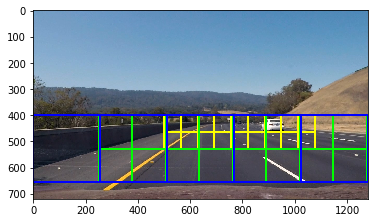

In [18]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

import glob
%matplotlib inline

img = mpimg.imread("test_images/test3.jpg")
    
windows_max = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 670], xy_window=(256, 256), xy_overlap=(0.0, 0.0))
windows_inter = slide_window(img, x_start_stop=[250, None], y_start_stop=[400, 670],  xy_window=(128, 128), xy_overlap=(0.0, 0.0))
windows_min = slide_window(img, x_start_stop=[500, 1100], y_start_stop=[400, 535], xy_window=(64, 64), xy_overlap=(0.0, 0.0))
    
imcopy = np.copy(img)
for bbox in windows_min:
    cv2.rectangle(imcopy, bbox[0], bbox[1], (255,255,0), 6)   
for bbox in windows_inter:
    cv2.rectangle(imcopy, bbox[0], bbox[1], (0,255,0), 6)       
for bbox in windows_max:
    cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    
plt.imshow(imcopy)
plt.savefig('./output_images/03.sliding_windows.jpg')

### Hog Sub-sampling Window Search

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_sapce, cells_per_step=2):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_sapce)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = cells_per_step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                                
    return window_list, heatmap

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


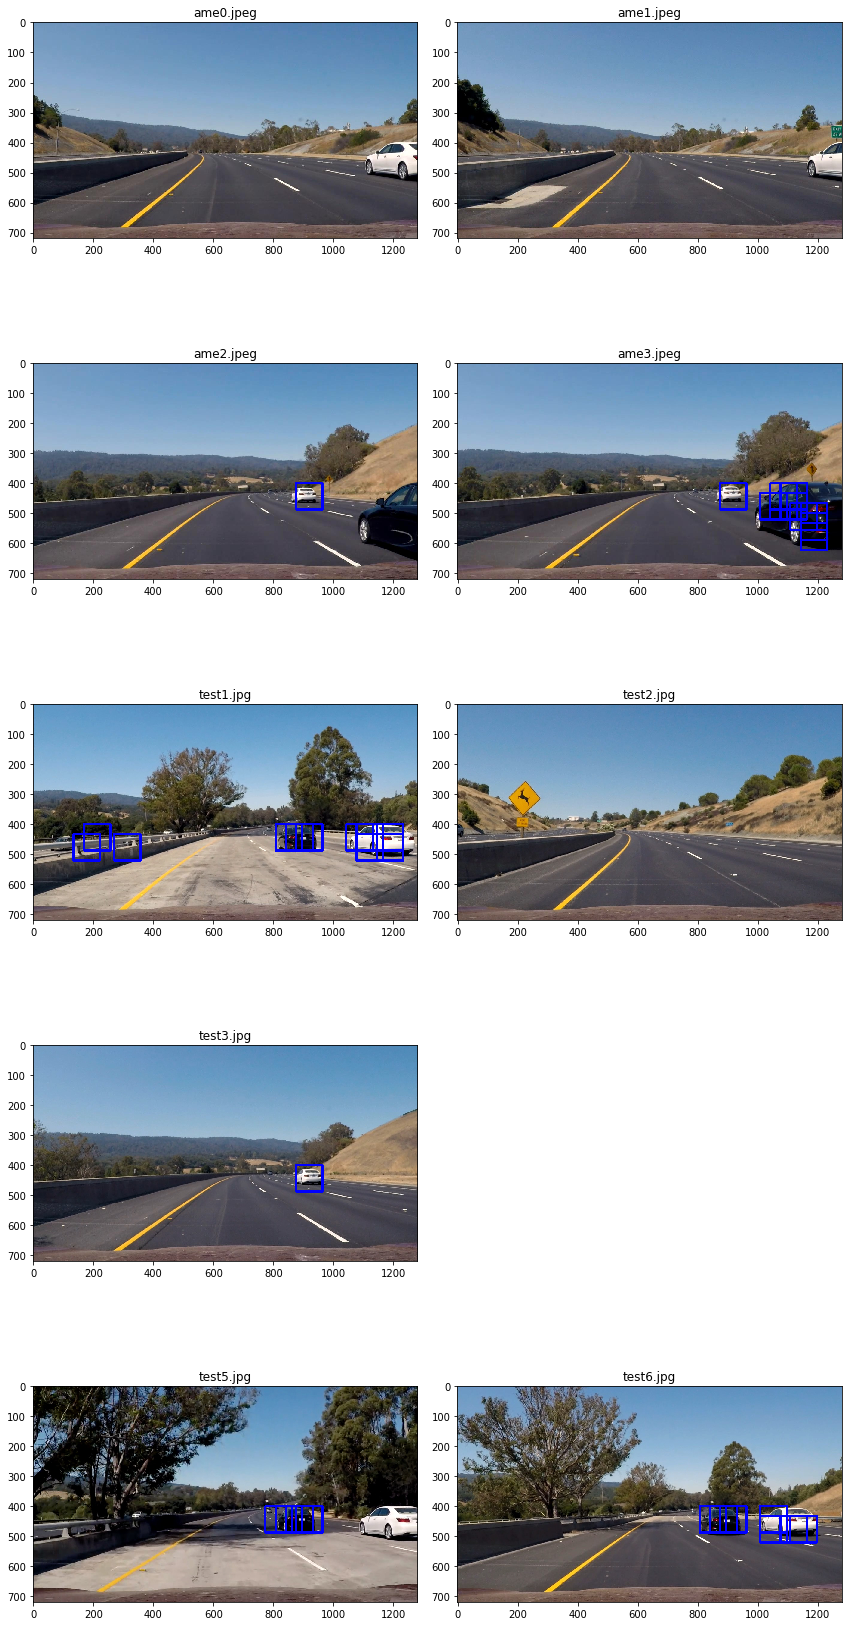

In [28]:
test_images = glob.glob('test_images/*')

out_images = []
out_titles = []

ystart = 400
ystop = 665
scale =  1.4
cells_per_step = 2

for img_src in test_images:
    img = mpimg.imread(img_src)
    windows, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step=cells_per_step)
    
    draw_img = np.copy(img)
    for bbox in windows:
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 0, 255), 6)  
    out_titles.append(img_src[-9:])
    out_images.append(draw_img)

fig = plt.figure(figsize=(12,24))
visualise(fig, 5, 2, out_images, out_titles)
fig.savefig("output_images/04.min_scaled_windows.jpg")

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


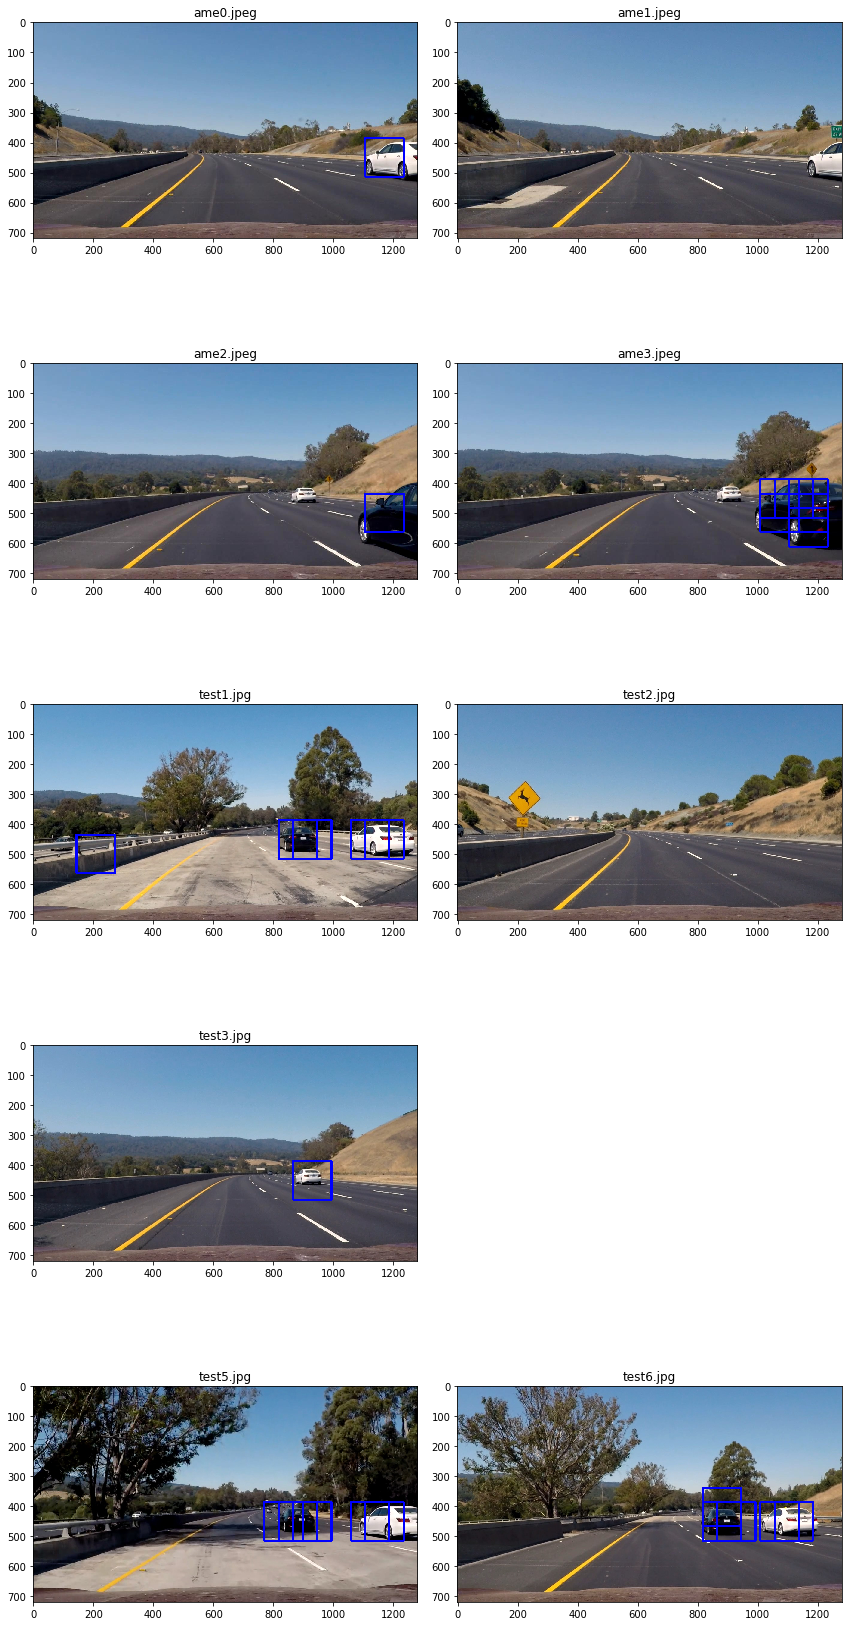

In [34]:
test_images = glob.glob('test_images/*')

out_images = []
out_titles = []

ystart = 340
ystop = 665
scale = 2
cells_per_step = 2

for img_src in test_images:
    img = mpimg.imread(img_src)
    windows, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step)
    
    draw_img = np.copy(img)
    for bbox in windows:
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 0, 255), 6)  
    out_titles.append(img_src[-9:])
    out_images.append(draw_img)
    
fig = plt.figure(figsize=(12,24))
visualise(fig, 5, 2, out_images, out_titles)
fig.savefig("output_images/05.max_scaled_windows.jpg")

In [35]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), thick)
    # Return the image
    return img

/Users/ElsaW/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.40550034046173095  seconds per image


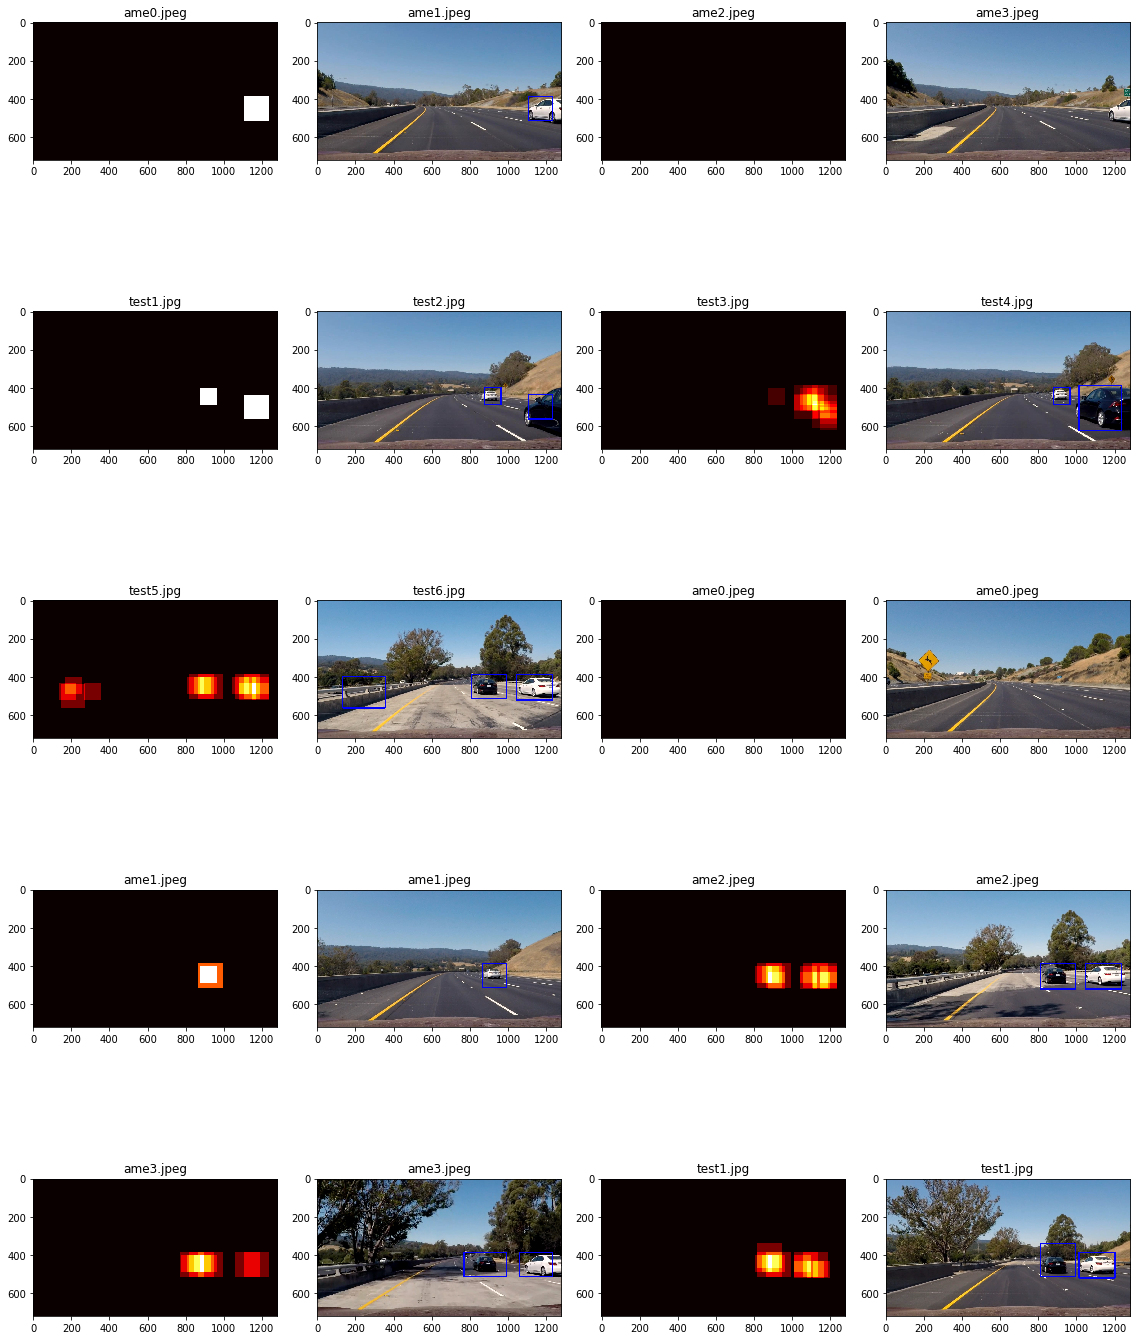

In [37]:
out_images = []

ystart1 = 400
ystop1 = 665
scale1 =  1.4
cells_per_step1 = 2

ystart2 = 340
ystop2 = 665
scale2 = 2
cells_per_step2 = 2

t = time.time()

for img_src in test_images:
    img = mpimg.imread(img_src)

    windows1, heatmap = find_cars(img, ystart1, ystop1, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step=cells_per_step1)
    windows2, heatmap2 = find_cars(img, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step=cells_per_step2)
    heatmap += heatmap2
    
    out_images.append(heatmap)
    
    heat = apply_threshold(heatmap,0)
    heatmap_thresholded = np.clip(heat, 0, 255)
        
    labels = label(heatmap_thresholded)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])

print((time.time()-t)/len(out_images), " seconds per image")

fig = plt.figure(figsize=(16,24))
visualise(fig, 6, 4, out_images, out_titles)
fig.savefig("output_images/06.heat_labeled.jpg")

In [67]:
from collections import deque

ystart1 = 400
ystop1 = 665
scale1 =  1.4
cells_per_step1 = 2

ystart2 = 340
ystop2 = 665
scale2 = 2
cells_per_step2 = 2

ma = 10

def pipeline(img):
    global heatmaps
  
    windows1, heatmap = find_cars(img, ystart1, ystop1, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step=cells_per_step1)
    windows2, heatmap2 = find_cars(img, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, cells_per_step=cells_per_step2)
    heatmap += heatmap2
    
    heatmaps.append(heatmap)
    summed_heatmap = np.sum(heatmaps, axis = 0)
    
    heat = apply_threshold(summed_heatmap, 5)      
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels, thick = 4)
    
    return draw_img

In [62]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
heatmaps = deque(maxlen = ma)
test_output = 'output_test.mp4'
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(pipeline)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_test.mp4
[MoviePy] Writing video output_test.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test.mp4 

CPU times: user 21 s, sys: 2.92 s, total: 23.9 s
Wall time: 30.8 s


In [64]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))

In [68]:
heatmaps = deque(maxlen = ma)
output = 'project5.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(pipeline)
#output_clip = clip.fl_image(pipeline).subclip(28, 30)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project5.mp4
[MoviePy] Writing video project5.mp4


100%|█████████▉| 1260/1261 [23:40<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5.mp4 

CPU times: user 13min 56s, sys: 1min 53s, total: 15min 49s
Wall time: 23min 42s


In [69]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output))